In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,sys,copy
from loguru import logger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, f1_score
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
import plotly.express as px

# import the tools required for data analysis and modeling from tools.ipynb
%run tools.ipynb

EDA = Analysis()

In [195]:
# load the csvfile as a pandas dataframe and visualize the head
EDA.read_display('hf_data.csv')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [196]:
# describe the stats for each column
EDA.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [197]:
# missing values in each column
EDA.nullval()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

#### There are no missing values

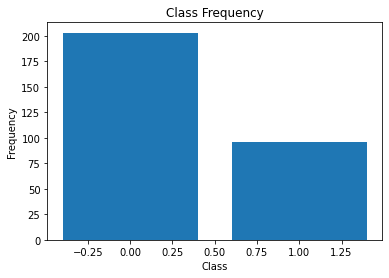

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [198]:
# number of instances for each predictive label
EDA.unique(count = True, column = 'DEATH_EVENT')

#### We are dealing with imbalanced dataset. We will resample to have equal number instances for each label. But first let's visualize the data

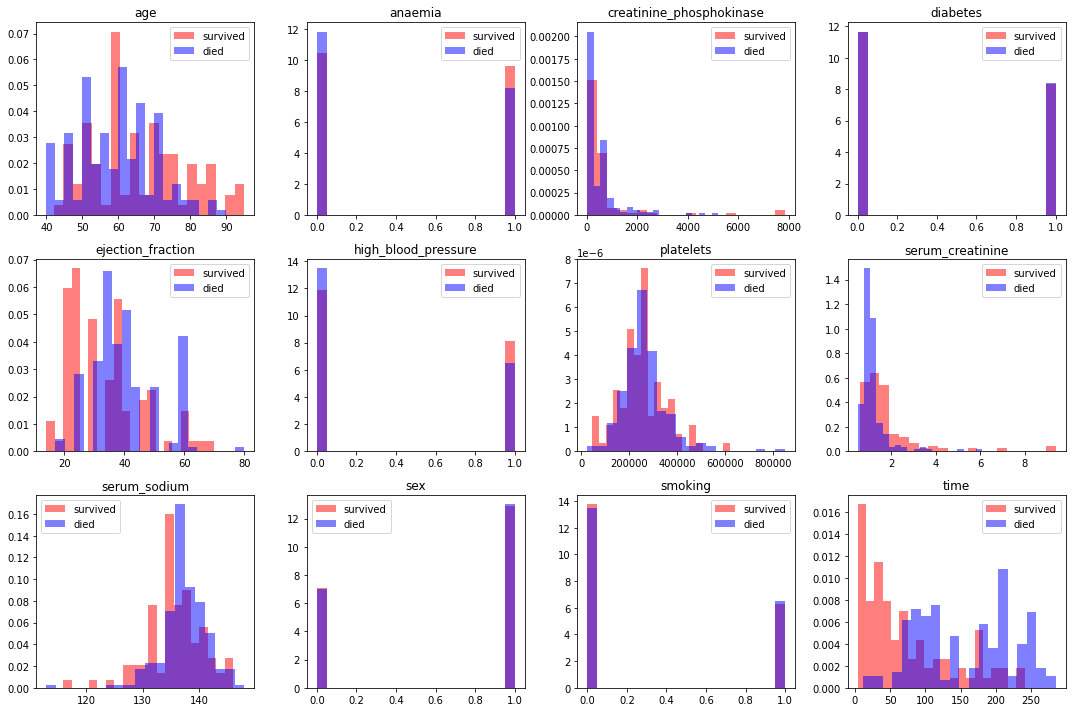

In [199]:
df = EDA.data

features = df.columns.drop('DEATH_EVENT')

fig,axes = plt.subplots(3,4, figsize = (15,10))
axes = axes.ravel()
for f,ax in zip(features,axes):
    
    
    ax.hist(df[f][df.DEATH_EVENT==1],label='survived',bins=20,density = True,  
                                color ='red', 
                                alpha = 0.5)
    ax.hist(df[f][df.DEATH_EVENT==0],label='died',bins=20,density = True,  
                                color ='blue',
                                alpha = 0.5)
    
    ax.set_title(f)
    ax.legend()
    
    
fig.tight_layout()    
plt.show()

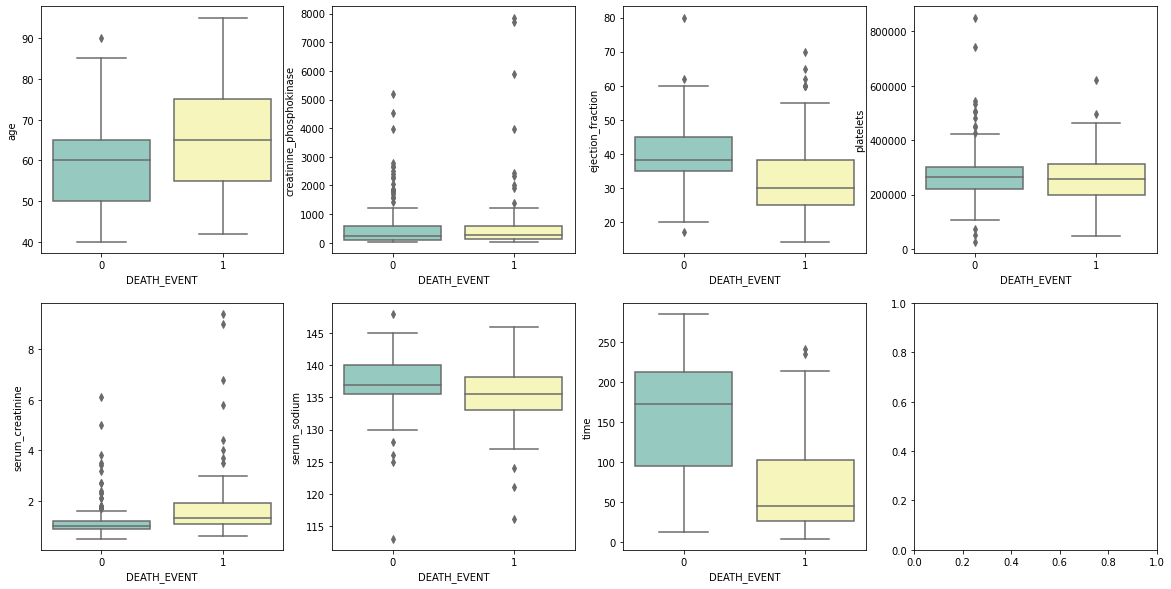

In [200]:
fig,axes = plt.subplots(2,4, figsize = (20,10))
axes = axes.ravel()
non_binary_features = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium', 'time']
for f,ax in zip(non_binary_features,axes):    
    sns.boxplot(x="DEATH_EVENT", y=f, data=df, ax = ax ,palette="Set3")    

In [201]:
# correlation map between each column
EDA.correlation()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000,0.088,-0.082,-0.101,0.060,0.093,-0.052,0.159,-0.046,0.065,0.019,-0.224,0.254
anaemia,0.088,1.000,-0.191,-0.013,0.032,0.038,-0.044,0.052,0.042,-0.095,-0.107,-0.141,0.066
creatinine_phosphokinase,-0.082,-0.191,1.000,-0.010,-0.044,-0.071,0.024,-0.016,0.060,0.080,0.002,-0.009,0.063
diabetes,-0.101,-0.013,-0.010,1.000,-0.005,-0.013,0.092,-0.047,-0.090,-0.158,-0.147,0.034,-0.002
ejection_fraction,0.060,0.032,-0.044,-0.005,1.000,0.024,0.072,-0.011,0.176,-0.148,-0.067,0.042,-0.269
high_blood_pressure,0.093,0.038,-0.071,-0.013,0.024,1.000,0.050,-0.005,0.037,-0.105,-0.056,-0.196,0.079
platelets,-0.052,-0.044,0.024,0.092,0.072,0.050,1.000,-0.041,0.062,-0.125,0.028,0.011,-0.049
serum_creatinine,0.159,0.052,-0.016,-0.047,-0.011,-0.005,-0.041,1.000,-0.189,0.007,-0.027,-0.149,0.294
serum_sodium,-0.046,0.042,0.060,-0.090,0.176,0.037,0.062,-0.189,1.000,-0.028,0.005,0.088,-0.195
sex,0.065,-0.095,0.080,-0.158,-0.148,-0.105,-0.125,0.007,-0.028,1.000,0.446,-0.016,-0.004


#### The columns sex, diabetes, smoking, anaemia, platelets, creatinine_phosphokinase and high_blood_pressure have their correlation value less than 0.1 with the DEATH_EVENT. So we will drop these columns from our dataframe

In [202]:
features_to_drop = []
for col in df.columns:
    if abs(df[col].corr(df.DEATH_EVENT)) < 0.05:
        features_to_drop.append(col)

# drop the columns
data = EDA.drop_features(features_to_drop)
data.head(4)

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,75.0,0,582,20,1,1.9,130,4,1
1,55.0,0,7861,38,0,1.1,136,6,1
2,65.0,0,146,20,0,1.3,129,7,1
3,50.0,1,111,20,0,1.9,137,7,1


In [203]:
# normalize the non-binary columns 
features_to_normalize = data.columns
EDA.normalize(features_to_normalize)

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,0.636364,0.0,0.071319,0.090909,1.0,0.157303,0.485714,0.000000,1.0
1,0.272727,0.0,1.000000,0.363636,0.0,0.067416,0.657143,0.007117,1.0
2,0.454545,0.0,0.015693,0.090909,0.0,0.089888,0.457143,0.010676,1.0
3,0.181818,1.0,0.011227,0.090909,0.0,0.157303,0.685714,0.010676,1.0
4,0.454545,1.0,0.017479,0.090909,0.0,0.247191,0.085714,0.014235,1.0
5,0.909091,1.0,0.003062,0.393939,1.0,0.179775,0.542857,0.014235,1.0
6,0.636364,1.0,0.028451,0.015152,0.0,0.078652,0.685714,0.021352,1.0
7,0.363636,1.0,0.037254,0.696970,0.0,0.067416,0.514286,0.021352,1.0
8,0.454545,0.0,0.017096,0.772727,0.0,0.112360,0.714286,0.021352,1.0
9,0.727273,1.0,0.012758,0.318182,1.0,1.000000,0.571429,0.021352,1.0


#### Since our dataset is imbalanced, we upsample the minority class. We first divide our data into train and test sets and then use the data in train set to upsample the minority class so to create equal number of classes in the training set.

In [204]:
X_train, X_test, Y_train, Y_test = EDA.imbalancesplit(Y_column = 'DEATH_EVENT', task = 'up')
# X_train, X_test, Y_train, Y_test = EDA.balancesplit(Y_column = 'DEATH_EVENT')
model = []

Train distribution: 1.0    162
0.0    162
Name: DEATH_EVENT, dtype: int64
Test distribution: 0.0    41
1.0    19
Name: DEATH_EVENT, dtype: int64


In [205]:
acc, f1 = EDA.logistic(X_train, X_test, Y_train, Y_test)
model.append([acc,f1,'Logistic'])

Train/Test split results:
 accuracy is 0.717
 precison is 0.538
 recall is 0.737
 auc is 0.820
 f1 score is 0.622


In [206]:
acc, f1 = EDA.svmclass(X_train, X_test, Y_train, Y_test, kernel = 'rbf')
model.append([acc,f1,'SVM'])

Train/Test split results:
 accuracy is 0.800
 precison is 0.652
 recall is 0.789
 auc is 0.859
 f1 score is 0.714


In [207]:
acc, f1 = EDA.randomforest(X_train, X_test, Y_train, Y_test, depth = 8)
model.append([acc,f1,'RandomForest'])

Train/Test split results:
 accuracy is 0.800
 precison is 0.652
 recall is 0.789
 auc is 0.858
 f1 score is 0.714


In [208]:
acc, f1 = EDA.decisiontree(X_train, X_test, Y_train, Y_test, depth = 5)
model.append([acc,f1,'DecisionTree'])

Train/Test split results:
 accuracy is 0.650
 precison is 0.464
 recall is 0.684
 auc is 0.761
 f1 score is 0.553


In [209]:
acc, f1 = EDA.gradientboost(X_train, X_test, Y_train, Y_test, depth = 8)
model.append([acc,f1,'GradientB'])

Train/Test split results:
 accuracy is 0.700
 precison is 0.529
 recall is 0.474
 auc is 0.745
 f1 score is 0.500


In [210]:
acc, f1 = EDA.XGboost(X_train, X_test, Y_train, Y_test)
model.append([acc,f1,'XGBoost'])

Train/Test split results:
 accuracy is 0.800
 precison is 0.706
 recall is 0.632
 auc is 0.833
 f1 score is 0.667


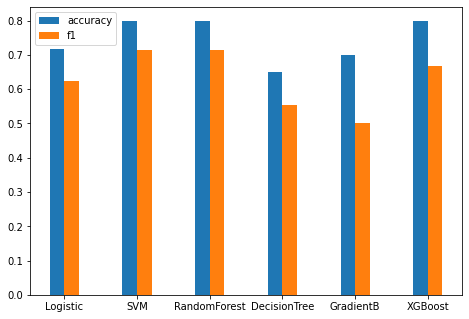

In [211]:
df = pd.DataFrame(model, columns=['acc', 'f1', 'mod'])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = np.arange(df['mod'].count())
acc_bar = ax.bar(x-0.1,df.acc, width = 0.2, label = 'accuracy')
f1_bar = ax.bar(x+0.1,df.f1, width = 0.2, label = 'f1')
ax.set_xticks(x)
ax.set_xticklabels(df['mod'])
ax.legend()
plt.show()